Luiz Carlos Irber Jr

ECS 253 - Network Theory

UC Davis

This document is available online at https://github.com/luizirber/ecs253/blob/master/hw2/Homework%202.ipynb

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import sympy
from sympy import init_printing
init_printing()

import pandas as pd

import graph_tool as gt

MAX_ITERS = 1000

In [3]:
from IPython.display import Image, SVG

# Problem 1

## a

Trivial case: if $d=0$, there are 0 vertices at exactly distance one (only the central node exists in this network).

For $d>0$, since every node has degree $k$ (except those at the maximum depth $d$), there are $k$ vertices at exactly distance one from the center.

## b

Trivial case: if $d<2$, there are 0 vertices at exactly distance two.

For $d>2$ each node at distance one ($k$ of them) has $k-1$ 'children' and one 'parent' (the central node), so there are $2k$ vertices at exactly distance two.

## c

Trivial cases: 
- if $d<l$, there are 0 vertices at exactly distance $l$.
- if $d>l$, there are 0 vertices at exactly distance $l$.

$v(1) = k$

$v(2) = 2n(1) = 2k$

$v(3) = 2n(2) = 4k$

$v(4) = 2n(3) = 8k$

$v(l) = 2^{l-1} k$

## d

$n(l) = 2^lk - 2$

In [3]:
def n(l, k=3):
    if l == 0:
        return 1
    
    return k * 2**l - 2

In [23]:
[n(x, 3) for x in range(10)]

[1, 4, 10, 22, 46, 94, 190, 382, 766, 1534]

## e

In [27]:
def d(n, k):
    return np.log(n) / np.log(k)

[d(n(x, 3), 3) for x in range(10)]

[0.0,
 1.2618595071429148,
 2.0959032742893848,
 2.8135880922155954,
 3.4849795837717283,
 4.1354851289511938,
 4.7760471335357595,
 5.4117550567493096,
 6.0450645220726171,
 6.6771818025269631]

# Problem 2



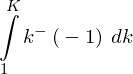

In [87]:
γ, k, K = sympy.symbols("γ k K")
P_K = sympy.Integral((γ-1)*k**(-γ), (k, 1, K))
P_K

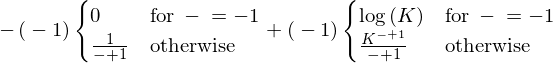

In [88]:
P_K.doit()

In [89]:
def P_Kv(K, γ):
    return (1 + K ** (-γ + 1)) / (-γ + 1)

In [90]:
def Kmax(N=10, gamma=2):
    return N ** (1/(gamma-1))

print("gamma=2: ", round(Kmax(1000, gamma=2), 2))
print("gamma=3: ", round(Kmax(1000, gamma=3), 2))
print("gamma=4: ", round(Kmax(1000, gamma=4), 2))

gamma=2:  1000.0
gamma=3:  31.62
gamma=4:  10.0


# Problem 3

## a

The dataset is a de Bruijn graph of the _Escherichia Coli_ genome, more specifically this one:
https://www.ncbi.nlm.nih.gov/nuccore/545778205

I constructed the graph using both 5-mers (512 possible nodes) and 13-mers (33,554,432 possible nodes) to show how the connectiveness of the graph changes. I built it using a directed graph (from networkx), and an undirected version is easy to extract from it.

## b

### Stats for the 5-mer graph:

In [5]:
!snakemake -n outputs/ecoli.5.stats
!cat outputs/ecoli.5.stats

Nothing to be done.
Name: Directed version
Type: DiGraph
Number of nodes: 512
Number of edges: 4088
Average in degree:   7.9844
Average out degree:   7.9844

Name: Undirected version
Type: Graph
Number of nodes: 512
Number of edges: 2076
Average degree:   8.1094



The 5-mers graph is almost a complete graph: all the possible 5-mers ($4^5$ permutations of "ACGT", divided by 2 due to reverse complement) are present in the graph, and almost all edges are present too (4088 out of 4096).
5-mers are too short to represent the genome properly.

### Stats for the 13-mer graph:

In [29]:
!snakemake -n outputs/ecoli.13.stats
!cat outputs/ecoli.13.stats

rule nx_stats:
	input: outputs/ecoli.13.gml
	output: outputs/ecoli.13.stats
Job counts:
	count	jobs
	1	nx_stats
	1
Name: Directed version
Type: DiGraph
Number of nodes: 3852750
Number of edges: 8043967
Average in degree:   2.0879
Average out degree:   2.0879

Name: Undirected version
Type: Graph
Number of nodes: 3852750
Number of edges: 6056732
Average degree:   3.1441



The 13-mer graph has 3852750 (out of 33554432, or ~11%) of all possible 13-mers. We can also see that average node degree is also lower.

## c

The degree distribution is not so interesting for a de Bruijn graph, because each node can have at most degree 8 (if undirected) or 16 (if directed).

The k-mer abundance is used to show how many times each k-mer showed up in the genome, and can be considered as a node weight (and, effectively, can also represented edge weights if you take the minimum value between two nodes connected by an edge). This information is important during genome assembly (it can be a bimodal distribution, useful for classifying erroneous and true k-mers), but since this data comes from an already assembled genome (which doesn't have many errors) the distribution either shows the saturation of the graph (for the 5-mer case) or 

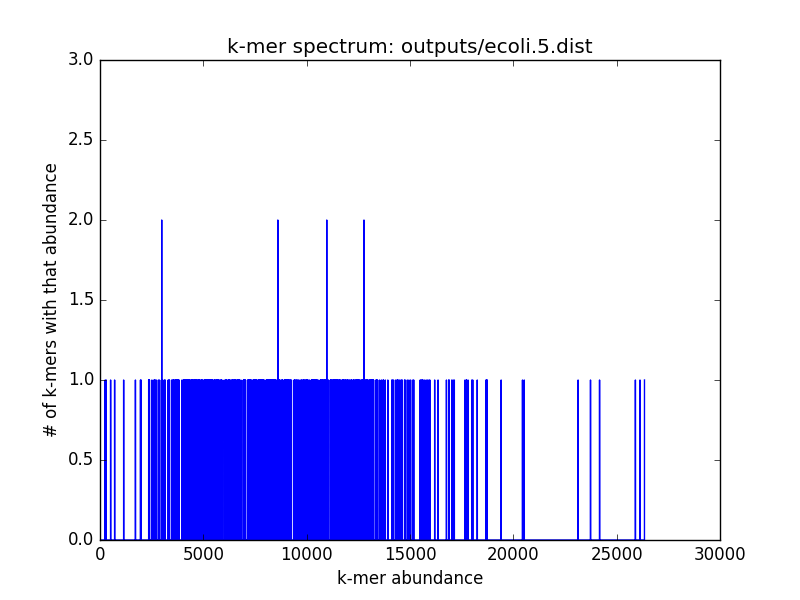

In [7]:
!python scripts/plot-abundance-dist.py --ymax 3 outputs/ecoli.5.dist outputs/ecoli.5.abundance.png
Image("outputs/ecoli.5.abundance.png")

Nothing to be done.


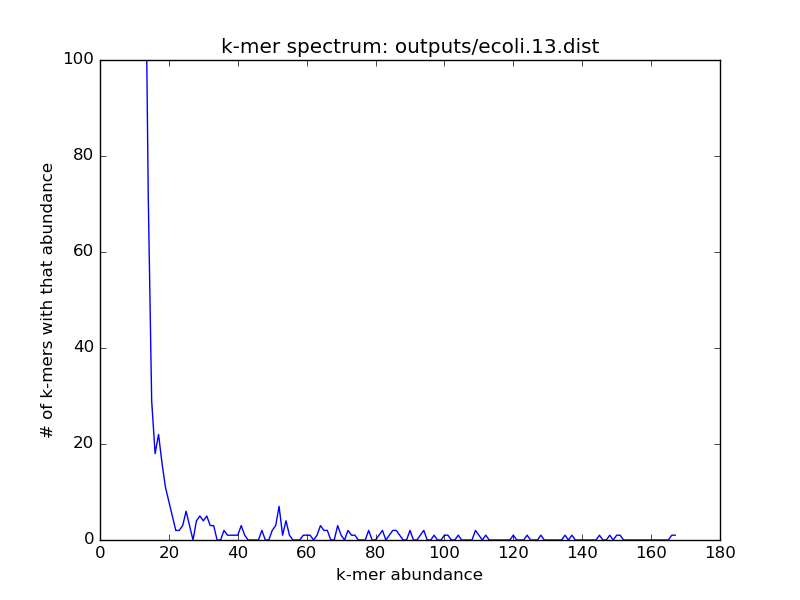

In [11]:
!snakemake -n outputs/ecoli.13.abundance.png
Image("outputs/ecoli.13.abundance.png")

/home/luizirber/Envs/ecs253/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


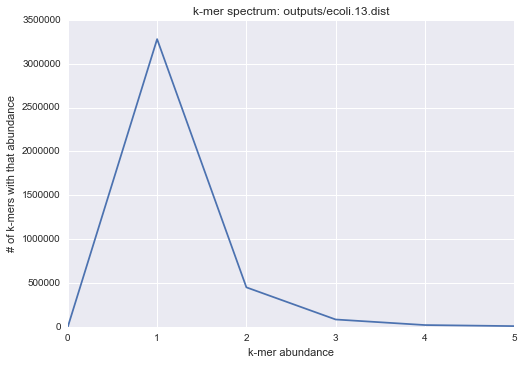

In [38]:
%run scripts/plot-abundance-dist.py --xmax 5 outputs/ecoli.13.dist outputs/ecoli.13.dist.png

We can see most k-mers only occur once, with only a few k-mers occuring many times.

I used the package 'powerlaw' to fit the abundance and check if it is indeed a power law:

In [58]:
import powerlaw

x = np.loadtxt("outputs/ecoli.13.dist", delimiter=',', skiprows=1)
f = powerlaw.Fit(x[:,1], discrete=True)
print("alpha:", f.power_law.alpha)
print("xmin:", f.power_law.xmin)
R, p = f.distribution_compare('power_law', 'lognormal') 
print("""*** Loglikelihood ratio of the two distributions' fit to the data. If
    greater than 0, the first distribution is preferred. If less than
    0, the second distribution is preferred.""")
print("Loglikelihood:", R)
print("p-value:", p)

powerlaw.Fit?

alpha: 1.24434485049
xmin: 5.0
*** Loglikelihood ratio of the two distributions' fit to the data. If
    greater than 0, the first distribution is preferred. If less than
    0, the second distribution is preferred.
Loglikelihood: -0.113787674586
p-value: 0.744267761106


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


The results show an alpha of $1.24$, starting from $x=5$, but the distribution comparison shows it fits better a lognormal distribution.

## d

I couldn't finish the 13-mers graph analysis, because it took too long.

I chose to use the abundance to represent both color and size of nodes. This is the color scale:

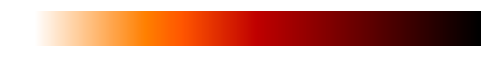

In [59]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
img = plt.imshow(gradient, aspect=10, cmap=plt.get_cmap("gist_heat_r"))
plt.gca().set_axis_off()

Nothing to be done.


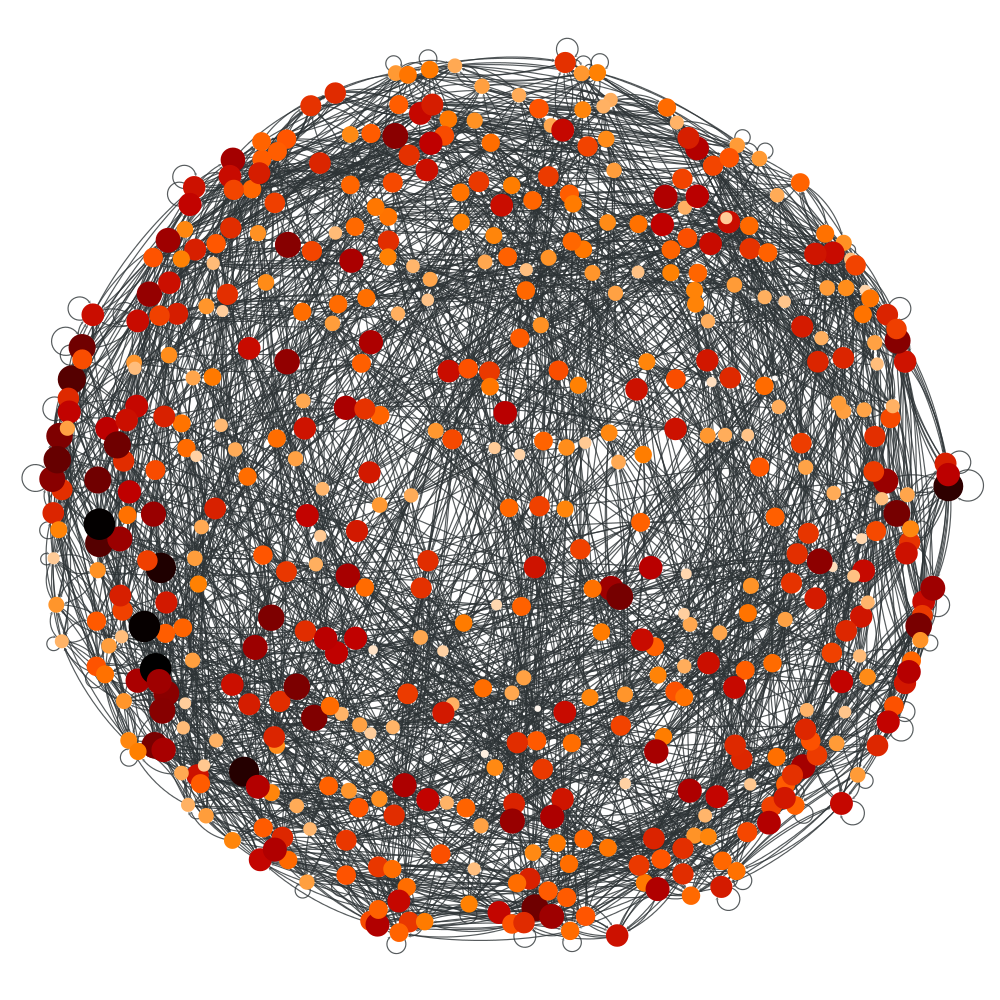

In [13]:
!snakemake -n outputs/ecoli.5.png
Image("outputs/ecoli.5.png")

## e

I used the `minimize_blockmodel_dl` method from graph-tool to generate the communities. I tried first with the python-louvain package, but it uses networkx and it doesn't scale well to a graph with millions of nodes. Even graph-tool took too long to run, and I couldn't add the community information for the 13-mer graph.

Community detection is more interesting in the context of more complex genomes (and specially metagenomes), but _E.coli_ only have one chromosome (more chromosomes could separate into communities). In metagenomes each community would probably separate into different species.

Nothing to be done.


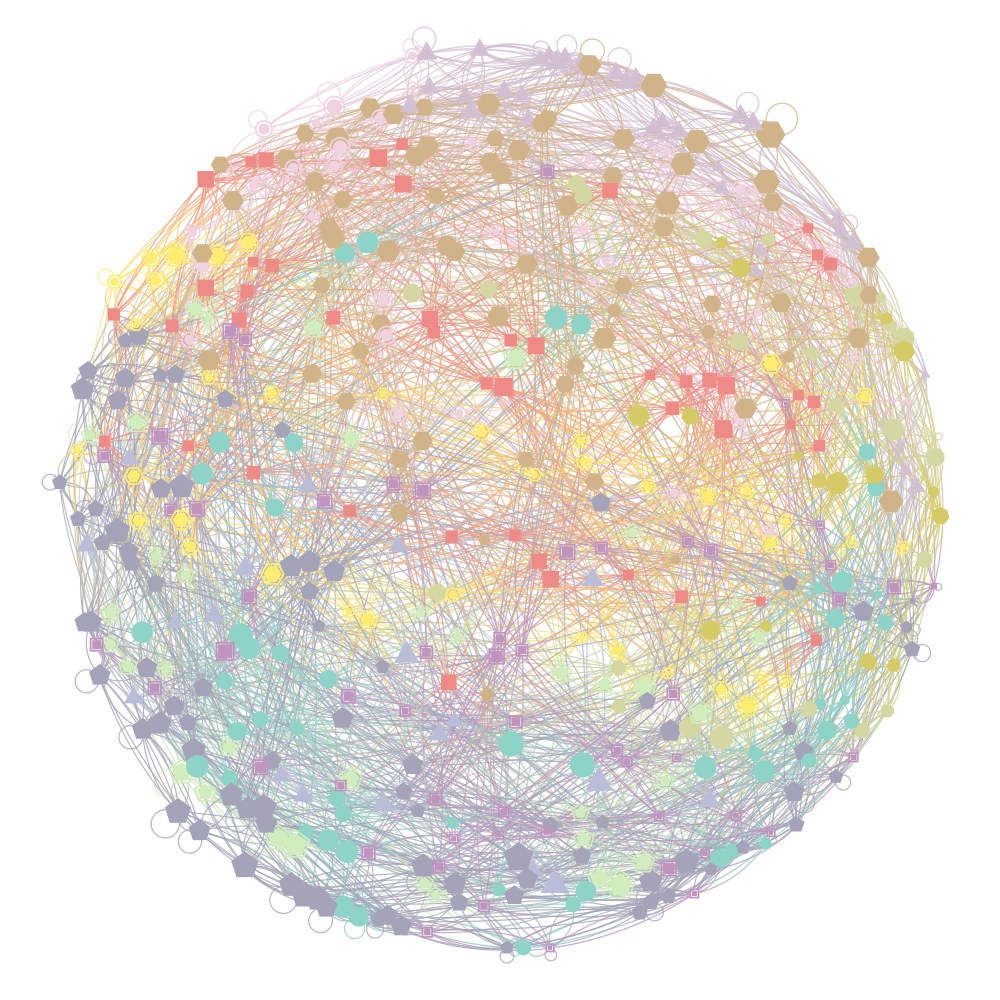

In [15]:
!snakemake -n outputs/ecoli.5.community.png
Image("outputs/ecoli.5.community.png")

12

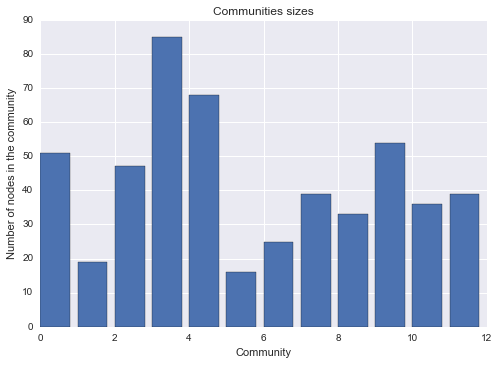

In [60]:
import yaml
with open("outputs/ecoli.5.community.yaml", 'r') as f:
    data = yaml.load(f)
plt.bar(list(data['sizes'].keys()), list(data['sizes'].values()))
plt.xlabel("Community")
plt.ylabel("Number of nodes in the community")
plt.title("Communities sizes")
len(data['sizes'])

Graph-tool also has another method, `minimize_nested_blockmodel_dl`, which can be used to visualize the relations between communities. It detected more communities than the previous method.

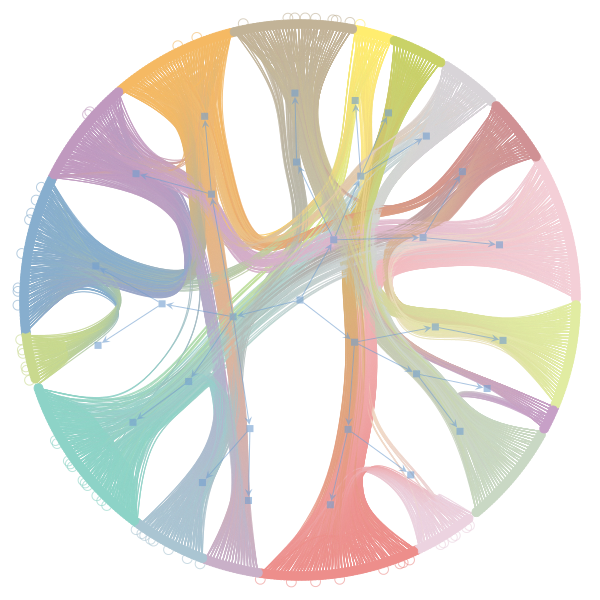

In [62]:
#!snakemake -n outputs/ecoli.5.hierarchy.png
Image("outputs/ecoli.5.hierarchy.png")

18

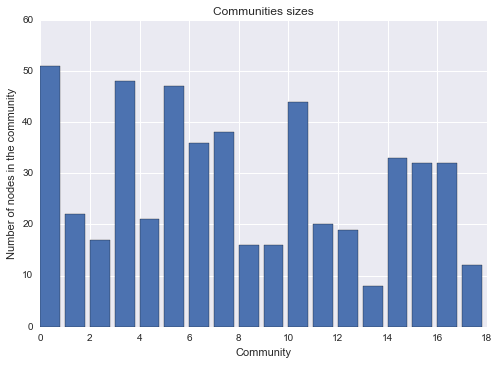

In [63]:
import yaml
with open("outputs/ecoli.5.hierarchy.yaml", 'r') as f:
    data = yaml.load(f)
plt.bar(list(data['sizes'].keys()), list(data['sizes'].values()))
plt.xlabel("Community")
plt.ylabel("Number of nodes in the community")
plt.title("Communities sizes")
len(data['sizes'])

Despite detecting communities, they don't mean much because the 5-mer graph is saturated and doesn't represent the genome well. I'll keep the 13-mer graph detection running and update the online notebook when it finishes.

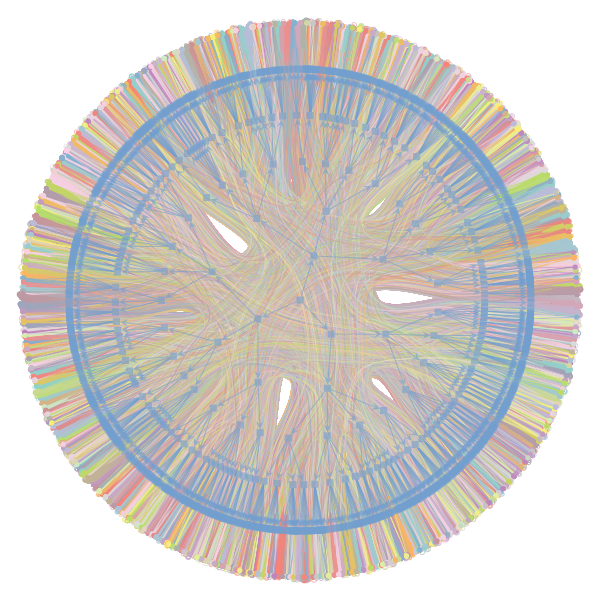

In [4]:
#!snakemake -n outputs/ecoli.13.hierarchy.png
Image("outputs/ecoli.13.hierarchy.png")

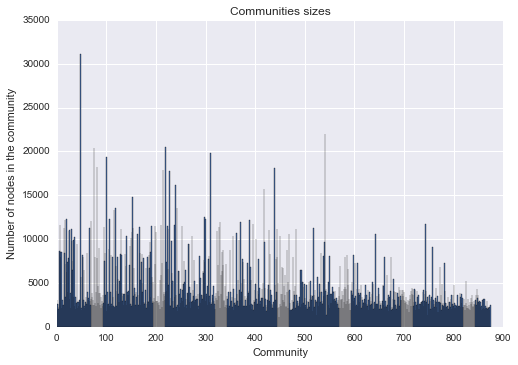

In [5]:
import yaml
with open("outputs/ecoli.13.hierarchy.yaml", 'r') as f:
    data = yaml.load(f)
plt.bar(list(data['sizes'].keys()), list(data['sizes'].values()))
plt.xlabel("Community")
plt.ylabel("Number of nodes in the community")
plt.title("Communities sizes")
len(data['sizes'])

# Bonus network

Here is the DAG for the tasks I defined to create the analysis (and available at https://github.com/luizirber/ecs253/tree/master/hw2)

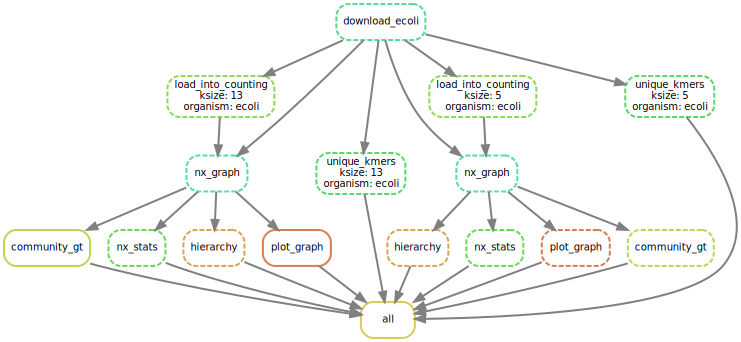

In [9]:
!snakemake --dag | dot -Tsvg > outputs/dag.svg
SVG('outputs/dag.svg')